Here's my title 

In [ ]:
import os
import pathlib  # manage filepaths
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files
from glob import glob  # Find files by pattern

import geopandas as gpd # process spatial vector data
import pandas as pd # data manipulation
import hvplot.pandas # interactive plots
import holoviews as hv
import numpy as np # Unpack bit-wise Fmask
import matplotlib.pyplot as plt #plot

import requests # Request data over HTTP
import cartopy.crs as ccrs # set/convert coord. reference system
import earthaccess # Access NASA data from the cloud
import rioxarray as rxr # Work with geospatial raster data
from rioxarray.merge import merge_arrays # Merge rasters
import regionmask # Convert shapefile to mask
from xrspatial import zonal_stats # Calculate zonal statistics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score

In [5]:
# Define and create the project data directory
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'redlining'
)
os.makedirs(data_dir, exist_ok=True)

# Define info for redlining download
redlining_url = (
    "https://dsl.richmond.edu/panorama/redlining/static"
    "/mappinginequality.gpkg"
)
redlining_dir = os.path.join(data_dir, 'redlining')
os.makedirs(redlining_dir, exist_ok=True)
redlining_path = os.path.join(redlining_dir, 'redlining.shp')

# Only download once
if not os.path.exists(redlining_path):
    redlining_gdf = gpd.read_file(redlining_url)
    redlining_gdf.to_file(redlining_path)

# Load from file and subset to Cleveland
redlining_gdf = gpd.read_file(redlining_path)

# Check the data
#redlining_gdf.plot()

c:\Users\chrmq\miniconda3\envs\earth-analytics-python\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\chrmq\earth-analytics\data\redlining\redlining\redlining.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [6]:
cleve_rl_gdf = redlining_gdf[redlining_gdf.city == "Cleveland"]
cleve_rl_gdf.hvplot(c='grade', legend=True, 
                  cmap="cet_cwr", geo=True, tiles='EsriImagery',
                  title="Historical Redlining in Cleveland, Ohio"
                  )

c:\Users\chrmq\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (grade)

In [7]:
cleve_bounds_gdf = cleve_rl_gdf.dissolve()

In [8]:
#Dissolve and plot against a basemap
cleve_rl_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    title='City of Cleveland',
    fill_color=None, line_color='darkorange', line_width=3,
    frame_width=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [9]:
earthaccess.login(strategy="interactive", persist=True)

In [ ]:
cleve_results = earthaccess.search_data(
    short_name="HLSL30",
    #cloud_hosted=True,
    bounding_box=tuple(cleve_rl_gdf.total_bounds),
    temporal=("2023-06-18"),
    #count=(-1)
)
#cleve_results
cleve_files = earthaccess.open(cleve_results)

QUEUEING TASKS | :   0%|          | 0/2715 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2715 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2715 [00:00<?, ?it/s]

In [14]:
cleve_results = earthaccess.search_data(
    short_name="HLSL30",
    #cloud_hosted=True,
    bounding_box=tuple(cleve_rl_gdf.total_bounds),
    temporal=("2023-07-26", "2023-07-26"),
    #count=45, 
)
#cleve_results
cleve_files = earthaccess.open(cleve_results) 

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

In [89]:
type(cleve_files)

list

In [15]:
cleve_files

[<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T17TMG.2023207T160935.v2.0/HLS.L30.T17TMG.2023207T160935.v2.0.B09.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T17TMG.2023207T160935.v2.0/HLS.L30.T17TMG.2023207T160935.v2.0.VZA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T17TMG.2023207T160935.v2.0/HLS.L30.T17TMG.2023207T160935.v2.0.B01.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T17TMG.2023207T160935.v2.0/HLS.L30.T17TMG.2023207T160935.v2.0.B05.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T17TMG.2023207T160935.v2.0/HLS.L30.T17TMG.2023207T160935.v2.0.B06.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earth

In [90]:
# Compile a regular expression to search for metadata
uri_re = re.compile(
    r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\.(?P<date>\d+)T\d+\.v2\.0\."
    r"(?P<band_id>.+)\.tif"
)
uri_re.search(cleve_files[8].full_name).groupdict()

{'tile_id': 'T17TMG', 'date': '2023207', 'band_id': 'Fmask'}

In [17]:
# Find all the metadata in the file name
uri_groups = [
    uri_re.search(cleve_file.full_name).groupdict()
    for cleve_file in cleve_files]

# Create a DataFrame with the metadata
raster_df = pd.DataFrame(uri_groups)

# Add the File-like URI to the DataFrame
raster_df['file'] = cleve_files

# Check the results
raster_df

,tile_id,date,band_id,file
0,T17TMG,2023207,B09,"<File-like object HTTPFileSystem, https://data..."
1,T17TMG,2023207,VZA,"<File-like object HTTPFileSystem, https://data..."
2,T17TMG,2023207,B01,"<File-like object HTTPFileSystem, https://data..."
3,T17TMG,2023207,B05,"<File-like object HTTPFileSystem, https://data..."
4,T17TMG,2023207,B06,"<File-like object HTTPFileSystem, https://data..."
5,T17TMG,2023207,B10,"<File-like object HTTPFileSystem, https://data..."
6,T17TMG,2023207,SAA,"<File-like object HTTPFileSystem, https://data..."
7,T17TMG,2023207,VAA,"<File-like object HTTPFileSystem, https://data..."
8,T17TMG,2023207,Fmask,"<File-like object HTTPFileSystem, https://data..."
9,T17TMG,2023207,B11,"<File-like object HTTPFileSystem, https://data..."


In [18]:
raster_df.columns

Index(['tile_id', 'date', 'band_id', 'file'], dtype='object')

In [ ]:
july26df = raster_df[raster_df['date']=='2023207']
july26df

,tile_id,date,band_id,file
150,T17TMG,2023207,B09,"<File-like object HTTPFileSystem, https://data..."
151,T17TMG,2023207,VZA,"<File-like object HTTPFileSystem, https://data..."
152,T17TMG,2023207,B01,"<File-like object HTTPFileSystem, https://data..."
153,T17TMG,2023207,B05,"<File-like object HTTPFileSystem, https://data..."
154,T17TMG,2023207,B06,"<File-like object HTTPFileSystem, https://data..."
155,T17TMG,2023207,B10,"<File-like object HTTPFileSystem, https://data..."
156,T17TMG,2023207,SAA,"<File-like object HTTPFileSystem, https://data..."
157,T17TMG,2023207,VAA,"<File-like object HTTPFileSystem, https://data..."
158,T17TMG,2023207,Fmask,"<File-like object HTTPFileSystem, https://data..."
159,T17TMG,2023207,B11,"<File-like object HTTPFileSystem, https://data..."


In [30]:
def process_cloud_mask(cloud_uri, bounds_gdf, bits_to_mask):
    """
    Load an 8-bit Fmask file and process to a boolean mask

    Parameters
    ----------
    uri: file-like or path-like
      Fmask file accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to
    bits_to_mask: list of int
      The indices of the bits to mask if set

    Returns
    -------
    cloud_mask: np.array
      Cloud mask
    """
    #Open fmask file
    fmask_da = process_image(cloud_uri, bounds_gdf)
    # Unpack the cloud mask bits
    cloud_bits = (
    np.unpackbits(
        (
            # Get the cloud mask as an array...
            fmask_da.values
            # ... of 8-bit integers
            .astype('uint8')
            # With an extra axis to unpack the bits into
            [:, :, np.newaxis]
        ), 
        # List the least significant bit first to match the user guide
        bitorder='little',
        # Expand the array in a new dimension
        axis=-1)
    )
    cloud_mask = np.sum(
    # Select bits 1, 2, and 3
    cloud_bits[:,:,bits_to_mask], 
    # Sum along the bit axis
    axis=-1
    # Check if any of bits are true
    ) == 0
    return cloud_mask

bits_to_mask = [
    1, # Cloud
    2, # Adjacent to cloud
    3, # Cloud shadow
    5] # Water

#cleve_cloud_mask = process_cloud_mask(cleve_files[8],
#cleve_bounds_gdf,
#                                       [1, 2, 3, 5])

In [31]:
# Labels for each band to process
bands = {
    'B02': 'blue',
    'B03': 'green',
    'B04': 'red',
    'B05': 'nir',
}
# Initialize structure for saving images
cleve_das = {band_name: [] for band_name in bands.values()}
print("Loading...")
for tile_id, tile_df in raster_df.groupby('tile_id'):
    print(tile_id)
    #display(tile_df)
    # Load the cloud mask
    fmask_file = tile_df[tile_df.band_id=='Fmask'].file.values[0]
    cloud_mask = process_cloud_mask(
        fmask_file, cleve_rl_gdf, [1, 2, 3, 5])
    #print(cloud_mask)

    for band_id, row in tile_df.groupby('band_id'):
        if band_id in bands:
            band_name = bands[band_id]
            print(band_id, band_name)
            
            # Process band
            band_da = process_image(row.file.values[0], cleve_rl_gdf)
            
            # Mask band
            band_masked_da = band_da.where(cloud_mask)
            #display(band_da)
            # Store the resulting DataArray ofr later
            cleve_das[band_name].append(band_masked_da)

print("Done.")


Loading...
T17TMF


C:\Users\chrmq\AppData\Local\Temp\ipykernel_45604\1290576236.py:28: RuntimeWarning: invalid value encountered in cast
  .astype('uint8')


B02 blue
B03 green
B04 red
B05 nir
T17TMG


C:\Users\chrmq\AppData\Local\Temp\ipykernel_45604\1290576236.py:28: RuntimeWarning: invalid value encountered in cast
  .astype('uint8')


B02 blue
B03 green
B04 red
B05 nir
Done.


<Axes: >

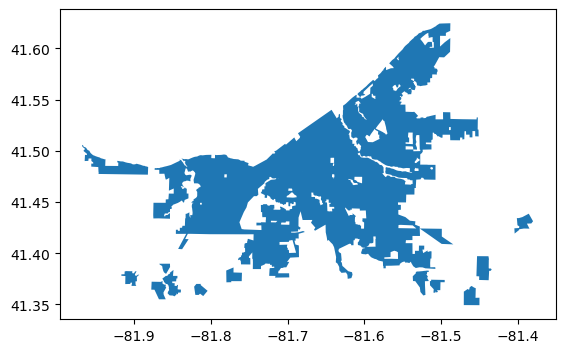

In [43]:
cleve_bounds_gdf.plot()

In [38]:
cleve_bounds_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
# Merge all tiles
cleve_merged_das = {
    band_name: merge_arrays(das) 
    for band_name, das 
    in cleve_das.items()}

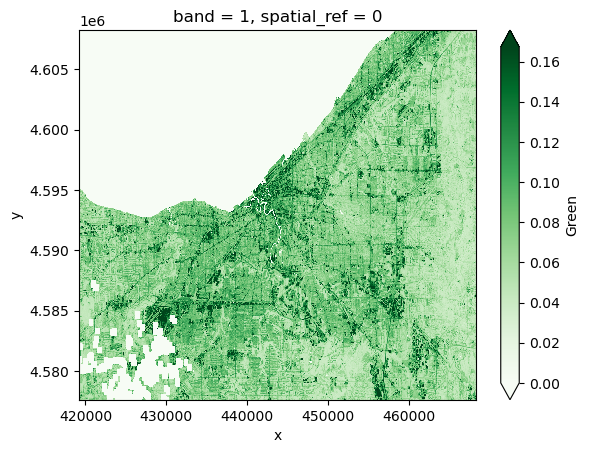

In [34]:
# Plot a merged raster band
cleve_merged_das['green'].plot(cmap='Greens', robust=True)

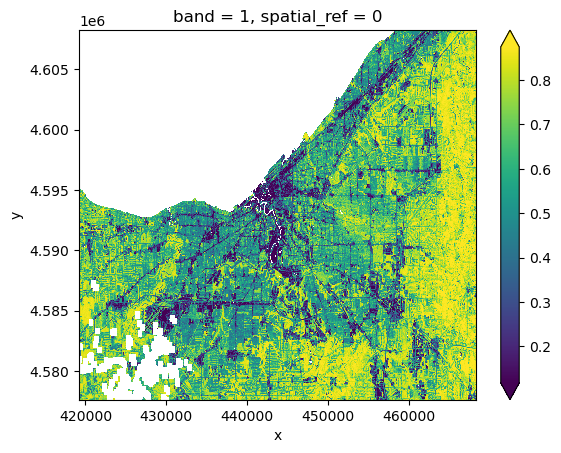

In [36]:
# Calculate NDVI
cleve_ndvi_da = (
    (cleve_merged_das['nir'] - cleve_merged_das['red']) /
     (cleve_merged_das['nir'] + cleve_merged_das['red'])
)
cleve_ndvi_da.plot(robust=True)

In [37]:
cleve_ndvi_da.rio.crs

CRS.from_epsg(32617)

In [43]:
cleve_rl_gdf32617.crs

<Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Ecuador - north of equator. Canada - Nunavut; Ontario; Quebec. Cayman Islands. Colombia. Costa Rica. Cuba. Jamaica. Nicaragua. Panama. United States (USA).
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
#Convert crs of the redlining gdf to match the HLSL30 raster data
cleve_rl_gdf32617 = cleve_rl_gdf.to_crs(32617)

In [46]:
cleve_redlining_mask = regionmask.mask_geopandas(
    cleve_rl_gdf32617,
    cleve_ndvi_da.x, cleve_ndvi_da.y,
    # The regions do not overlap
    overlap=False,
    # We're not using geographic coordinates
    wrap_lon=False
)

In [ ]:
# Calculate NDVI stats for each redlining zone
cleve_ndvi_stats = zonal_stats(cleve_redlining_mask, cleve_ndvi_da)
cleve_ndvi_stats

# Merge the NDVI stats with redlining geometry into one `GeoDataFrame`
cleve_ndvi_merged = cleve_rl_gdf32617.merge(cleve_ndvi_stats.set_index('zone'),
                                              left_index=True, right_index=True)

# Change grade to ordered Categorical for plotting
cleve_ndvi_merged.grade = pd.Categorical(
    cleve_ndvi_merged.grade,
    ordered=True,
    categories=['A', 'B', 'C', 'D']
)

# Drop rows with NA grades
cleve_ndvi_merged = cleve_ndvi_merged.dropna()



:Layout
   .Polygons.I  :Polygons   [x,y]   (mean)
   .Polygons.II :Polygons   [x,y]   (grade)

In [57]:
import xyzservices.providers as xyz
import holoviews as hv

In [58]:
hv.Tiles('https://tile.openstreetmap.org/{Z}/{X}/{Y}.png', name="OSM").opts(width=600, height=550)

:Tiles   [x,y]

In [87]:
# Plot NDVI and redlining grade in linked subplots
(
    cleve_ndvi_merged.hvplot(c='mean', geo=True, cmap='Greens')
    +
    cleve_ndvi_merged.hvplot(c='grade', geo=True,  cmap='cet_cwr')
)

:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (mean)
   .Polygons.II :Polygons   [Longitude,Latitude]   (grade)

In [84]:
cleve_ndvi_merged.crs

<Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Ecuador - north of equator. Canada - Nunavut; Ontario; Quebec. Cayman Islands. Colombia. Costa Rica. Cuba. Jamaica. Nicaragua. Panama. United States (USA).
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

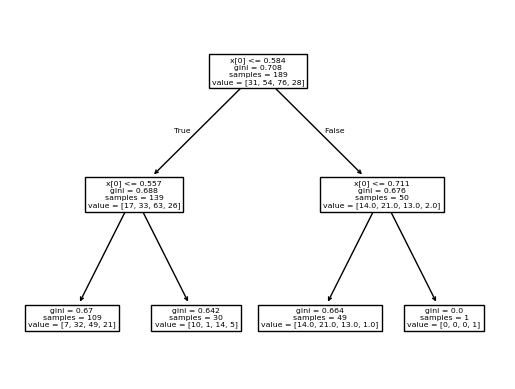

In [65]:
# Convert categories to numbers
cleve_ndvi_merged['grade_codes'] = cleve_ndvi_merged.grade.cat.codes
# #cleve_ndvi_merged.grade.cat.codes

# Fit model
tree_classifier = DecisionTreeClassifier(max_depth=2).fit(
    cleve_ndvi_merged[['mean']],
    cleve_ndvi_merged.grade_codes    
)

# Visualize tree
plot_tree(tree_classifier)
plt.show()

In [69]:
cleve_ndvi_merged['predictions'] = (tree_classifier
                                   .predict(cleve_ndvi_merged[['mean']]))
cleve_ndvi_merged[['grade_codes', 'predictions']]

cleve_ndvi_merged['error'] = (
    cleve_ndvi_merged['predictions'] - cleve_ndvi_merged['grade_codes']
)

cleve_ndvi_merged[['grade_codes', 'predictions', 'error']]

,grade_codes,predictions,error
7201.0,0,1,1
7202.0,0,2,2
7203.0,0,2,2
7204.0,0,2,2
7205.0,0,2,2
...,...,...,...
7386.0,3,2,-1
7387.0,3,2,-1
7388.0,3,3,0
7389.0,3,2,-1


In [82]:
#Need to convert to Mercator projection to map with geo=True
cleve_ndvi_merged_merc.hvplot(c='error', geo=True)

NameError: name 'cleve_ndvi_merged_merc' is not defined

In [71]:
cleve_ndvi_merged.head()

,area_id,city,state,city_surve,category,grade,label,residentia,commercial,industrial,...,mean,max,min,sum,std,var,count,predictions,grade_codes,error
7201.0,457,Cleveland,OH,True,Best,A,A1,True,False,False,...,0.634786,0.905044,0.092052,716.673462,0.131661,0.017335,1129.0,1,0,1
7202.0,430,Cleveland,OH,True,Best,A,A10,True,False,False,...,0.582783,0.882246,-0.126482,540.822449,0.118259,0.013985,928.0,2,0,2
7203.0,429,Cleveland,OH,True,Best,A,A11,True,False,False,...,0.557629,0.863750,0.124243,146.656494,0.117739,0.013862,263.0,2,0,2
7204.0,426,Cleveland,OH,True,Best,A,A12,True,False,False,...,0.578020,0.893554,-0.067623,396.521759,0.142106,0.020194,686.0,2,0,2
7205.0,427,Cleveland,OH,True,Best,A,A13,True,False,False,...,0.518350,0.793946,0.052823,181.940948,0.118438,0.014027,351.0,2,0,2


In [75]:
grade_means = cleve_ndvi_merged.groupby('grade').mean('mean')
grade_means

C:\Users\chrmq\AppData\Local\Temp\ipykernel_45604\2066640892.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grade_means = cleve_ndvi_merged.groupby('grade').mean('mean')


,area_id,city_surve,residentia,commercial,industrial,mean,max,min,sum,std,var,count,predictions,grade_codes,error
grade,,,,,,,,,,,,,,,
A,406.451613,1.0,1.0,0.0,0.0,0.589675,0.860408,0.107581,731.045389,0.120962,0.015330,1211.870968,1.548387,0.0,1.548387
B,394.574074,1.0,1.0,0.0,0.0,0.552065,0.858645,0.109812,793.053821,0.127954,0.017117,1381.703704,1.611111,1.0,0.611111
C,396.723684,1.0,1.0,0.0,0.0,0.534565,0.876018,0.082326,1081.761484,0.148262,0.022680,2027.684211,1.828947,2.0,-0.171053
D,966.500000,1.0,1.0,0.0,0.0,0.499172,0.841641,0.080817,1035.633409,0.154139,0.025285,2183.678571,2.000000,3.0,-1.000000
